The program implements the approach described in the PIMCO paper “Beyond Currency Hedging” (Appendix Section 7.1), 
applying it specifically to an international equity portfolio.

I find that the PIMCO framework offers a robust quantitative foundation for optimizing currency hedge ratios in global portfolios. It allows for the incorporation of forward-looking market information within a holistic structure that explicitly connects currency movements to the underlying equity portfolio. The framework employs a constrained optimization approach to maximize expected returns while managing key risks, including total portfolio volatility, FX tracking error, and the beta between currency and equity exposures.

As a case study, **the Oakmark International Fund (OANIX)** is used to illustrate the methodology.

At a high level, OANIX currently overweights Western Europe (75%) and South Korea (4%), while underweighting Japan (16%), 
Canada (10%), and Australia (3%). To explore potential FX hedging strategies, 
 examine a hypothetical scenario in which the fund shifts its allocation to overweight Japan.

Using the PIMCO methodology, the program calculates optimal currency hedge ratios under this new allocation, 
identifying the currency overlay that would best manage currency risk under the revised exposures. 
The portfolio weights are selected to analyze the potential benefits of the methodology 
and do not represent a real investment strategy.

The code executes the following steps:

Asset definition: Specifies a set of international equity ETFs, their associated currencies, and target portfolio weights.

Data acquisition: Utilizes yfinance to download historical price data for the selected ETFs and corresponding foreign exchange rates.

Return computation: Calculates monthly returns for both equity assets and FX rates.

Parameter estimation: Derives expected returns, volatilities, and the correlation matrix required for optimization.

Portfolio optimization: Solves for optimal FX hedge ratios that maximize expected portfolio return, subject to constraints on total portfolio volatility, FX tracking error, and FX-equity beta. The solution traces out an efficient frontier under these risk constraints.

While the PIMCO framework is originally intended for multi-asset global portfolios including both equities and bonds, this implementation adapts the approach to focus exclusively on managing currency risk within an international equity allocation.



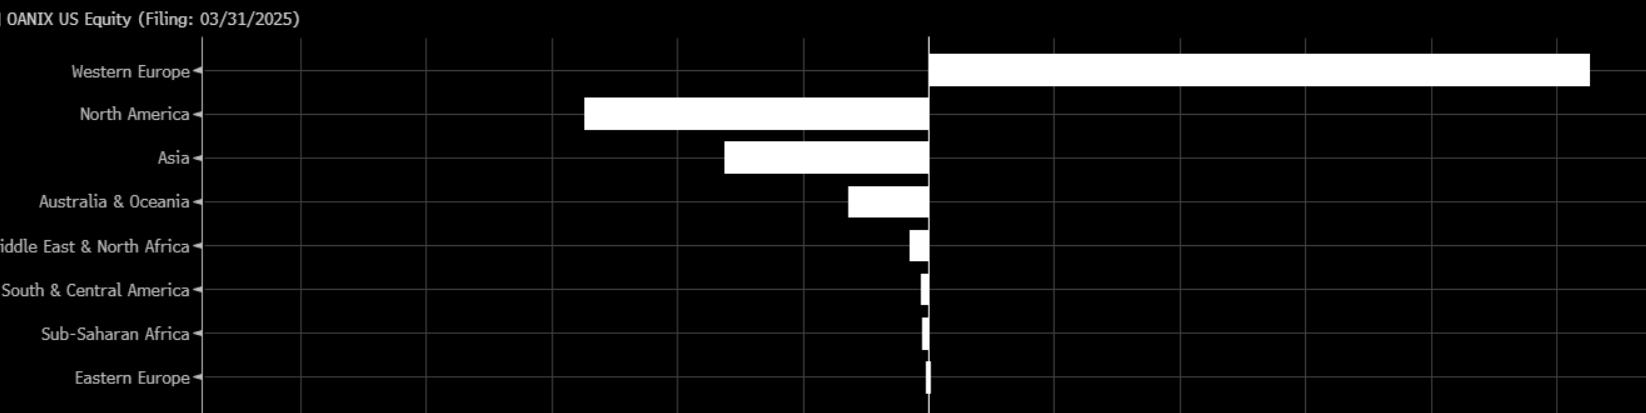

In [1]:
#%% OANIX Regional Exposure As of March 31, 2025

from IPython.display import Image, display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

display(Image(filename='OANIX_03312025.png',  height=1000))
 

In [2]:
#%% Load Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import cvxpy as cp
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.width', 200)        # Wider output in characters
pd.set_option('display.max_columns', 20)   # Adjust as needed


In [3]:
#%% Step 1: Define ETF and Currency Information 
# Defines a list of dictionaries containing asset information (country, currency, FX ticker, ETF ticker, 
# weights, and color for visualization), mimicking the PIMCO paper's portfolio composition. The paper 
# focuses on optimizing currency exposures for an equity portfolio, so this step sets up the asset 
# universe with initial (ext_weight) and target (new_weight) allocations.

lAssetMap = [
    {
        "country": "Japan", "currency": "JPY",
        "fx_ticker": "JPYUSD=X",
        "fx_type": "direct",
        "ext_weight": 0.05,
        "new_weight": 0.25,
        "etf_ticker": "EWJ",
        "color":'blue'
    },  
    
    {
        "country": "South Korea",
        "currency": "KRW",
        "fx_ticker": "KRWUSD=X",
        "fx_type": "direct",
        "ext_weight": 0.10,
        "new_weight": 0.05,
        "etf_ticker": "EWY",
        "color":'red'
    },
    {
        "country": "Canada",
        "currency": "CAD",
        "fx_ticker": "CADUSD=X",
        "fx_type": "direct",
        "ext_weight": 0.05,
        "new_weight": 0.15,
        "etf_ticker": "EWC",
        "color":'orange'
    },

    {
        "country": "Australia",
        "currency": "AUD",
        "fx_ticker": "AUDUSD=X",
        "fx_type": "direct",
        "ext_weight": 0.05,
        "new_weight": 0.05,
        "etf_ticker": "EWA",
        "color":'purple'
    },
    {
        "country": "Europe",
        "currency": "EUR",
        "fx_ticker": "EURUSD=X",
        "fx_type": "direct",
        "ext_weight": 0.75,
        "new_weight": 0.5,
        "etf_ticker": "VGK",
         "color":'green'
    },
]

tAssetInfo = pd.DataFrame(lAssetMap)

print(tAssetInfo)


       country currency fx_ticker fx_type  ext_weight  new_weight etf_ticker   color
0        Japan      JPY  JPYUSD=X  direct        0.05        0.25        EWJ    blue
1  South Korea      KRW  KRWUSD=X  direct        0.10        0.05        EWY     red
2       Canada      CAD  CADUSD=X  direct        0.05        0.15        EWC  orange
3    Australia      AUD  AUDUSD=X  direct        0.05        0.05        EWA  purple
4       Europe      EUR  EURUSD=X  direct        0.75        0.50        VGK   green


## Equity Portfolio Weights Review

The existing portfolio currently overweights Western Europe (75%) and South Korea (10%), while underweighting Japan (5%), Canada (5%), and Australia (3%). 

To explore potential FX hedging strategies, the new portfolio increases its allocation to Japan by 20% and to Canada by 10%, while reducing exposure to Europe by 25% and South Korea by 5%.

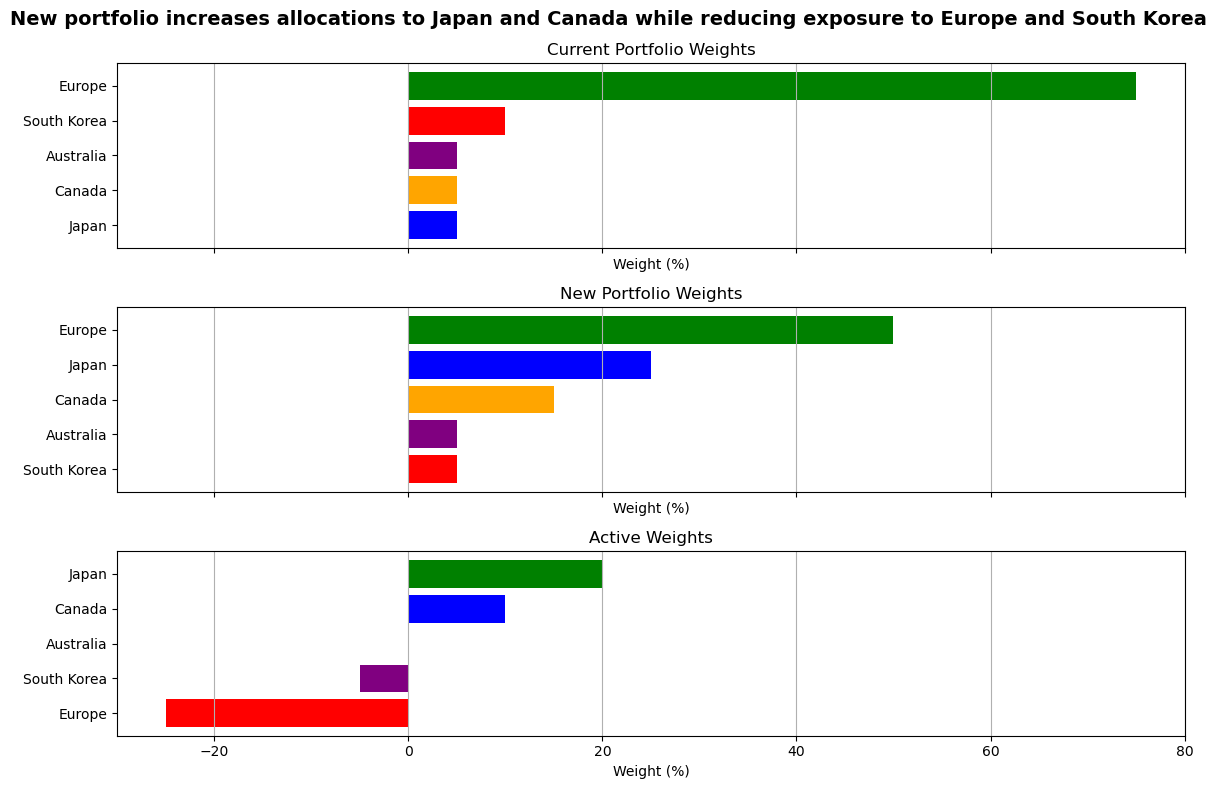

In [4]:
#%% Step 2: Set Portfolio weights and Review
# Normalizes the initial (ext_weight) and target (new_weight) allocations , reflecting the 
# portfolio's composition. The active weights (vActiveWeights) represent the shift from current to 
# new allocations.

vCurrWeights = np.array(tAssetInfo['ext_weight']/tAssetInfo['ext_weight'].sum())

vNewWeights = np.array(tAssetInfo['new_weight']/tAssetInfo['new_weight'].sum())

VActiveWeights = vNewWeights - vCurrWeights 

lAssetName = tAssetInfo['country'].to_list()
lColorName =   tAssetInfo['color'].to_list()

dictColorMap = dict(zip(lAssetName , lColorName))

# Create dataframes
dfCurrWeight = pd.DataFrame({"Ticker": lAssetName, "Weight": vCurrWeights}).sort_values(by="Weight", ascending=True)
dfNewWeight = pd.DataFrame({"Ticker": lAssetName, "Weight": vNewWeights}).sort_values(by="Weight", ascending=True)
dfActiveWeight = pd.DataFrame({"Ticker": lAssetName, "Weight": VActiveWeights}).sort_values(by="Weight", ascending=True)

# Create subplots to visualize weight distributions
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

fig.suptitle("New portfolio increases allocations to Japan and Canada while reducing exposure to Europe and South Korea", fontsize=14, fontweight='bold', y=0.98)

# Current Portfolio Weights
colors1 = [dictColorMap[ticker] for ticker in dfCurrWeight["Ticker"]]
axes[0].barh(dfCurrWeight["Ticker"], dfCurrWeight["Weight"] * 100, color=colors1)
axes[0].set_title("Current Portfolio Weights")
axes[0].set_xlabel("Weight (%)")
axes[0].grid(axis="x")

# New Portfolio Weights
colors2 = [dictColorMap[ticker] for ticker in dfNewWeight["Ticker"]]
axes[1].barh(dfNewWeight["Ticker"], dfNewWeight["Weight"] * 100, color=colors2)
axes[1].set_title("New Portfolio Weights")
axes[1].set_xlabel("Weight (%)")
axes[1].grid(axis="x")


# Active Portfolio Weights
colors3 = [dictColorMap[ticker] for ticker in dfActiveWeight["Ticker"]]
axes[2].barh(dfActiveWeight["Ticker"], dfActiveWeight["Weight"] * 100, color=colors2)
axes[2].set_title("Active Weights")
axes[2].set_xlabel("Weight (%)")
axes[2].grid(axis="x")

plt.tight_layout()
plt.show()

In [5]:
#%% Step 3: Download Historical Data
# Downloads historical price data for ETFs and FX rates using yfinance, 
# covering 2000-01-01 to 2025-05-31,
# to estimate statistical properties.

strFromDate = "2000-01-01"
strToDate = "2025-05-31"

lTicker = tAssetInfo[['etf_ticker', 'fx_ticker']].values.flatten().tolist()

bDownloadData = False # True

if bDownloadData:

    import yfinance as yf

    dictRawData = {}
    for strTicker in lTicker:
        print(f"Download: {strTicker}")
        
        df = yf.download(strTicker, start= strFromDate, end= strToDate)
        dictRawData[strTicker] = df

    with open('rawData.pkl', 'wb') as f:
        pickle.dump(dictRawData, f)

else:

    with open('rawData.pkl', 'rb') as f:
        dictRawData = pickle.load(f)



## Impact of Japan's Fiscal and Monetary Stimulus

Historically, the Japanese yen is a safe haven asset and tends to have a negative correlation with its equity market. 
However, since the aggressive fiscal stimulus announced by the Japanese government in late 2023, along with continued loose monetary policy, 
Japan's equity market and currency have started to show a positive relationship.


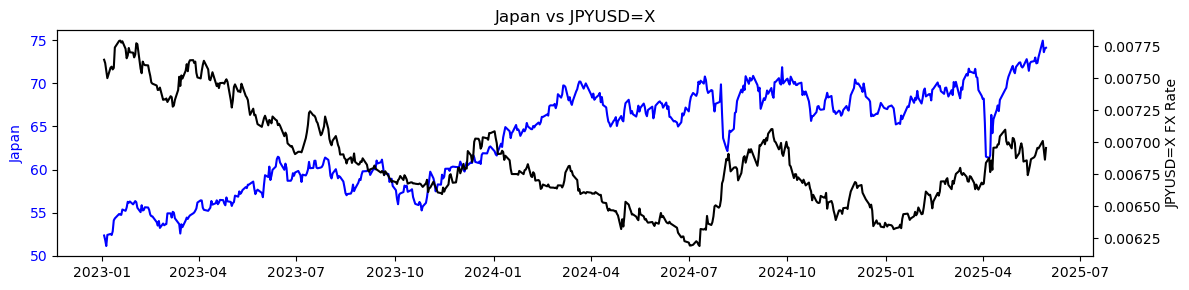

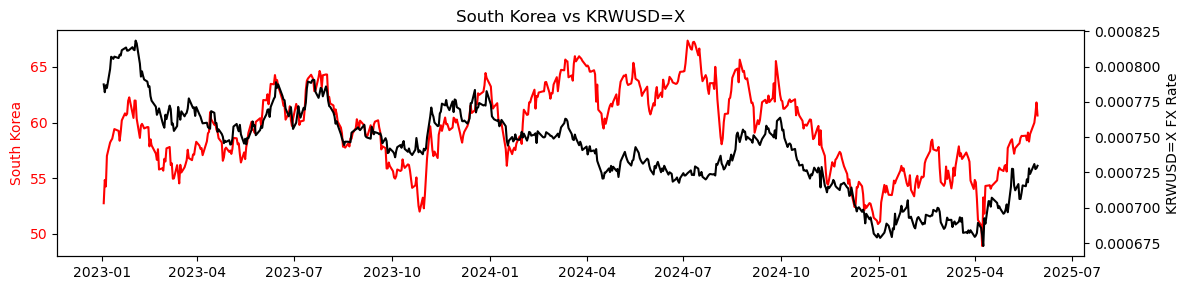

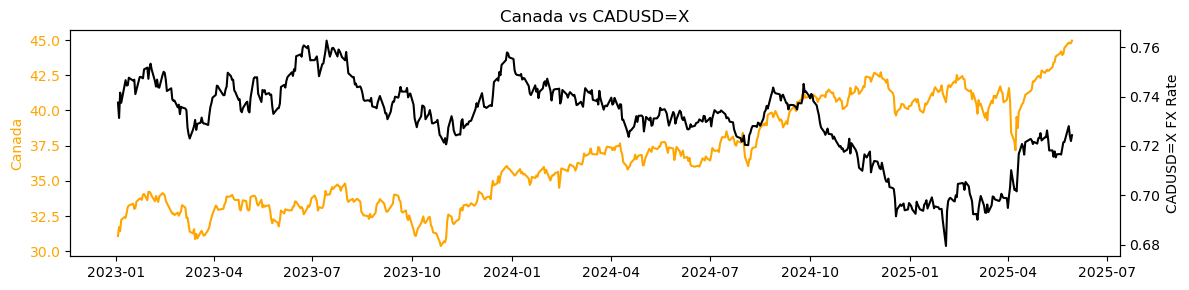

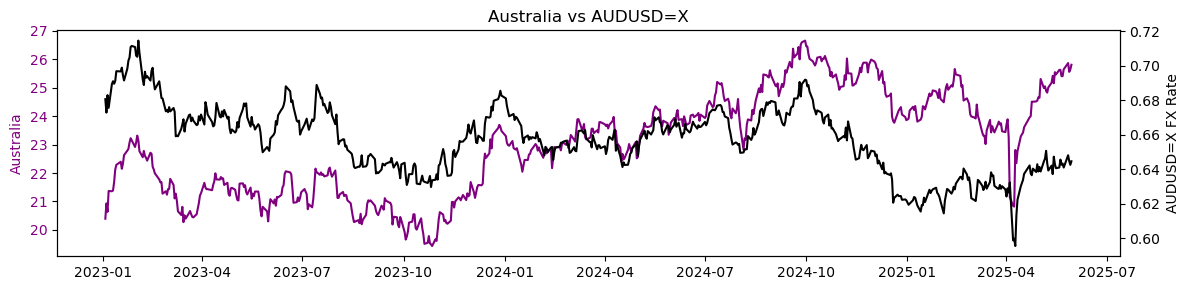

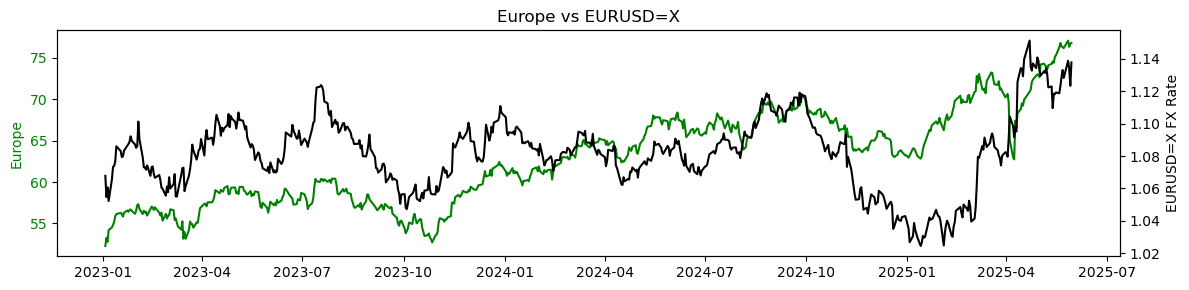

In [16]:
#%% Step 3: Process Data
# Processes the downloaded price data into a DataFrame and visualizes ETF prices against FX rates to
# assess their relationship, which the paper uses to inform currency hedging decisions.

dfPrice = pd.DataFrame(
        {strTicker: dictRawData[strTicker]['Close'].squeeze() for strTicker in lTicker } 
        ).dropna()


# focus on period from 2024
dPeriod = '2023'
for _, row in tAssetInfo.iterrows():
 
    # check
    fig, ax1 = plt.subplots(figsize=(12, 3))
    ax1.plot(dfPrice.loc[ dPeriod:,row["etf_ticker"] ], color= row["color"], label= row["country"])
    ax1.set_ylabel(row["country"], color= row["color"])
    ax1.tick_params(axis="y", labelcolor= row["color"])
    ax2 = ax1.twinx()
    ax2.plot(dfPrice.loc[ dPeriod:,row["fx_ticker"]], color= "black", label= row["fx_ticker"] )
    ax2.set_ylabel(f"{ row["fx_ticker"]} FX Rate", color="black")
    ax2.tick_params(axis="y", labelcolor="black")
    plt.title(f"{row["country"]} vs {row["fx_ticker"]}")
    fig.tight_layout()
    plt.show()

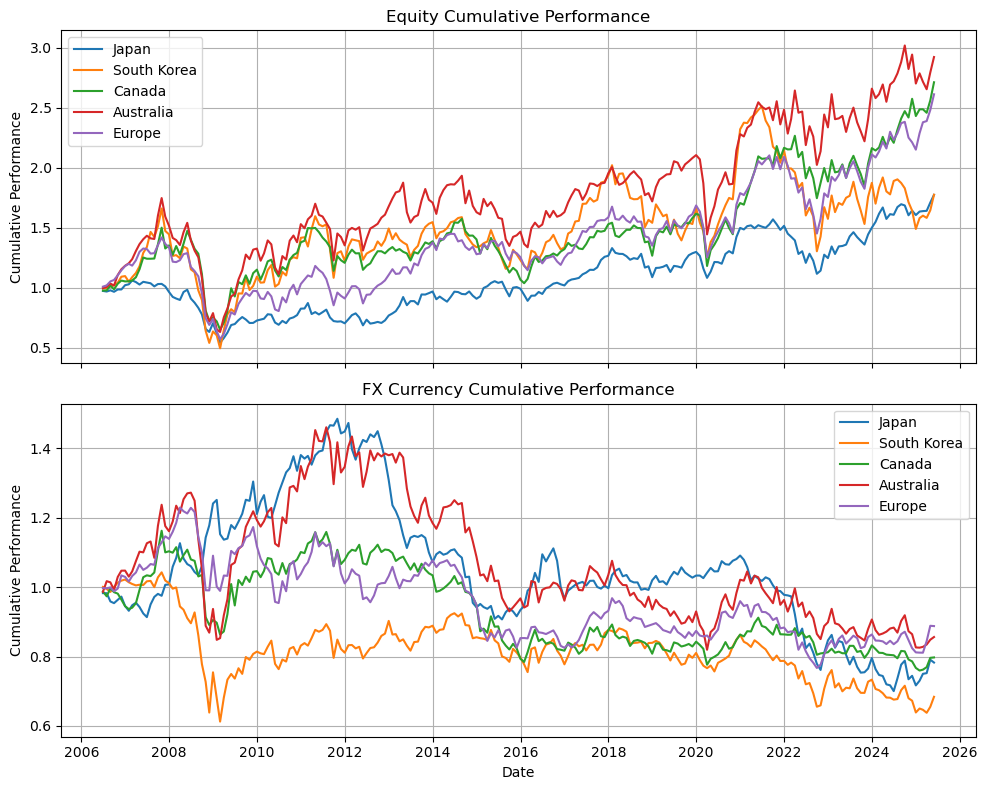

In [7]:
#%% Step 5: Process Returns data
# Computes monthly returns from price data and plots cumulative performance to analyze historical trends,
# aligning with the paper's use of historical data to estimate expected returns and risks.

dfReturn = dfPrice.resample('M').last().pct_change().dropna()


lETFTicker = tAssetInfo['etf_ticker'].tolist()
lCurrencyTicker = tAssetInfo['fx_ticker'].tolist()
lCountryTicker = tAssetInfo['country'].tolist()

dfEquityReturn = dfReturn[lETFTicker].copy().reset_index().set_index('Date')
dfFXReturn =  dfReturn[lCurrencyTicker].copy().reset_index().set_index('Date')
 

fig, axes = plt.subplots(2,1, figsize = (10, 8), sharex = True)

for _, row in tAssetInfo.iterrows(): 
    axes[0].plot((1 + dfEquityReturn[row['etf_ticker']]).cumprod(), label= row['country'])
axes[0].set_title("Equity Cumulative Performance")
axes[0].set_ylabel("Cumulative Performance")
axes[0].legend()
axes[0].grid()

for _, row in tAssetInfo.iterrows(): 
    axes[1].plot((1 + dfFXReturn[row['fx_ticker']]).cumprod(), label= row['country'])
axes[1].set_title("FX Currency Cumulative Performance")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Performance")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()
 

### Correlation Review Between Country Equity and Its Currency

Rolling correlation analysis shows that the Japanese yen tends to exhibit a negative correlation with its equity market during sell-offs. 
In contrast, the Australian and South Korean currencies display a strong positive relationship with risk-on rallies in their respective equity markets.

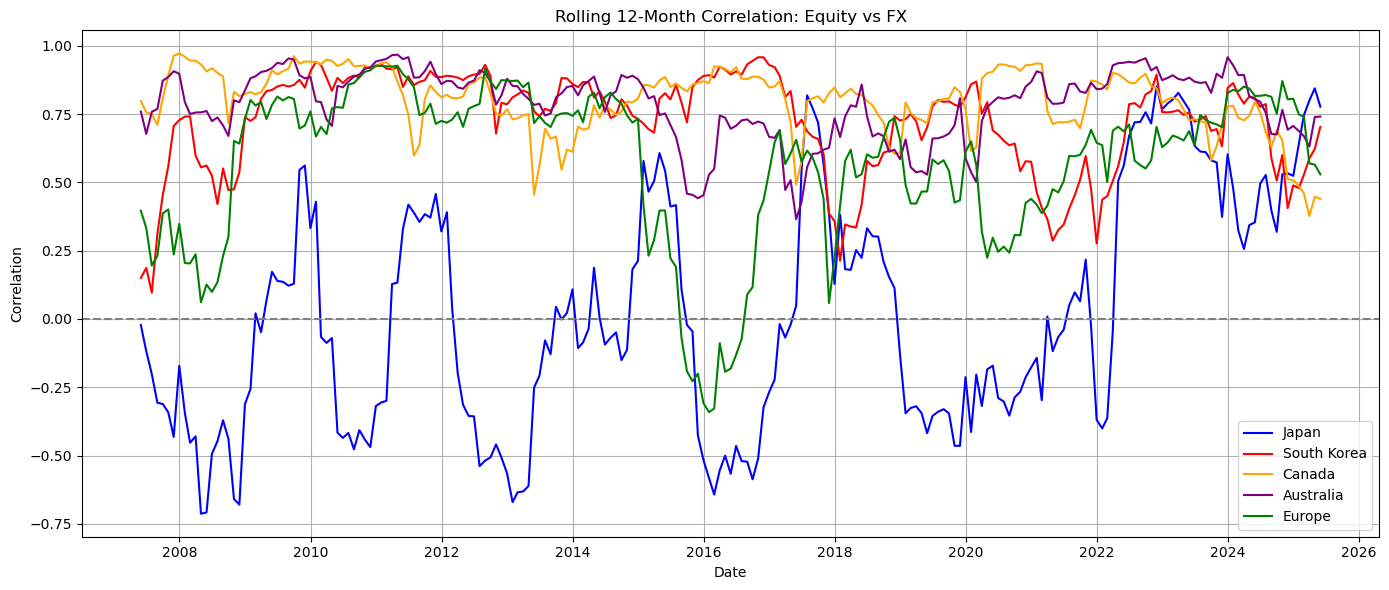

In [8]:
# rolling correlation between country equity and its currency movement against USD
dRollingWindow = 12

plt.figure(figsize = (14,6))
for _, row in tAssetInfo.iterrows():
    
    strEquityTicker = row["etf_ticker"]
    strFXTicker = row["fx_ticker"]
    strCountryTicker = row["country"]
    strColor = row["color"]

    dfRollCorr = dfReturn[strEquityTicker].rolling(window = dRollingWindow ).corr( dfReturn[strFXTicker])

    plt.plot( dfRollCorr.index, dfRollCorr, label = strCountryTicker, color = strColor)

# Decorate the plot
plt.title(f"Rolling {dRollingWindow }-Month Correlation: Equity vs FX")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Construct Portfolio Optimization Inputs 

### Equity Market Review

Using data from 2024 as a proxy for the current market environment, Japan has outperformed South Korea and Australia in terms of both returns and risk-adjusted performance.

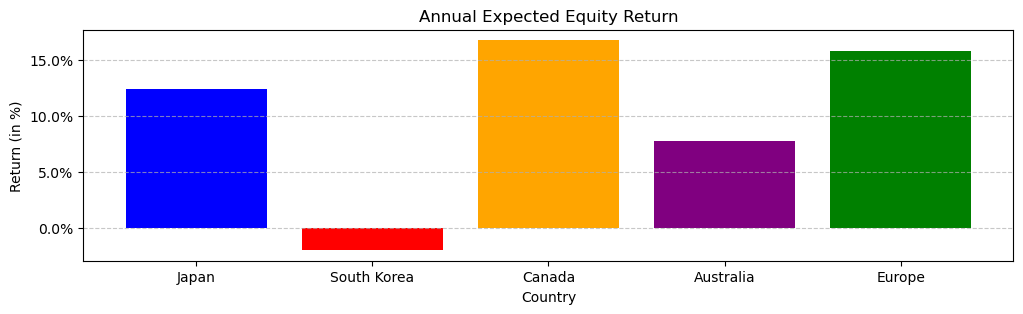

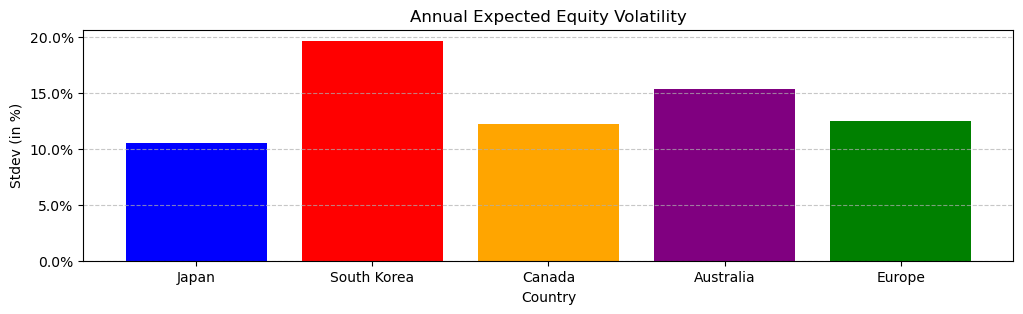

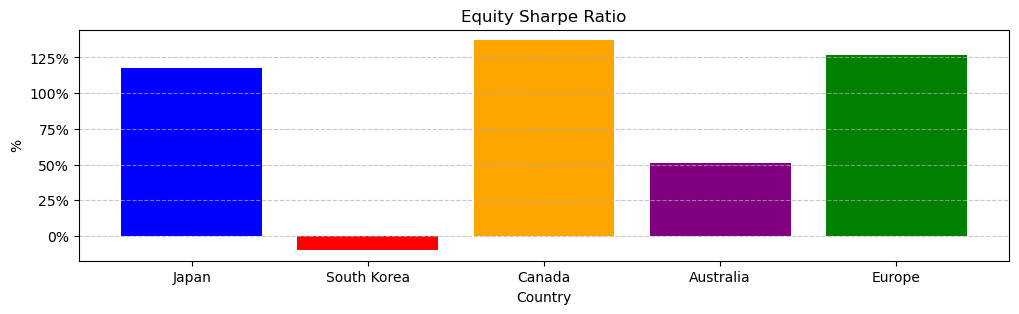

In [9]:
#%% Step 6: Construct Portfolio Optimization Inputs for Equity Portfolio
# Estimates annualized expected returns, volatilities, and Sharpe ratios for equity and FX assets,
# using historical data from 2024 onward, as a proxy for the paper's forward-looking assumptions.


dFrequency = 12

ExpectedEquityReturn = dfEquityReturn['2024':].mean() * dFrequency

ExpectedEquityVol = dfEquityReturn['2024':].std() * np.sqrt(dFrequency)

lEquityTicker = dfEquityReturn.columns.tolist()

plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = ExpectedEquityReturn, color = lColorName)
plt.title('Annual Expected Equity Return')
plt.xlabel('Country')
plt.ylabel('Return (in %)')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = ExpectedEquityVol, color = lColorName)
plt.title('Annual Expected Equity Volatility')
plt.xlabel('Country')
plt.ylabel('Stdev (in %)')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = (ExpectedEquityReturn/ExpectedEquityVol), color = lColorName)
plt.title('Equity Sharpe Ratio')
plt.xlabel('Country')
plt.ylabel('%')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### FX Market Review

Using data from 2024 as a proxy for the current market environment, the euro has outperformed the U.S. dollar, supported by expansive fiscal policy and accommodative monetary conditions. 
The next best-performing currency was the Japanese yen.
 

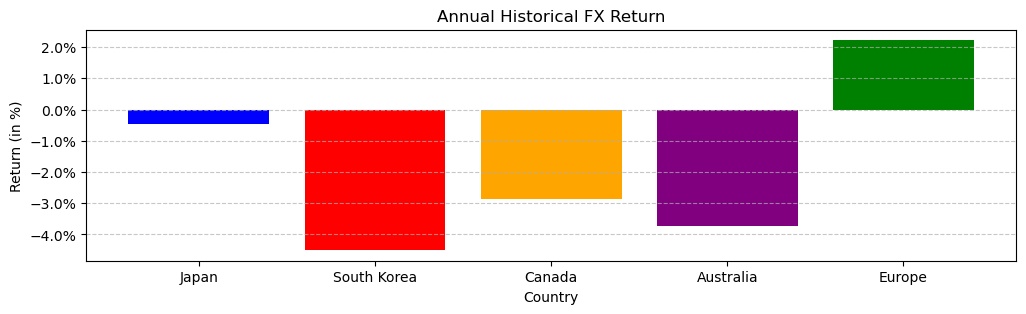

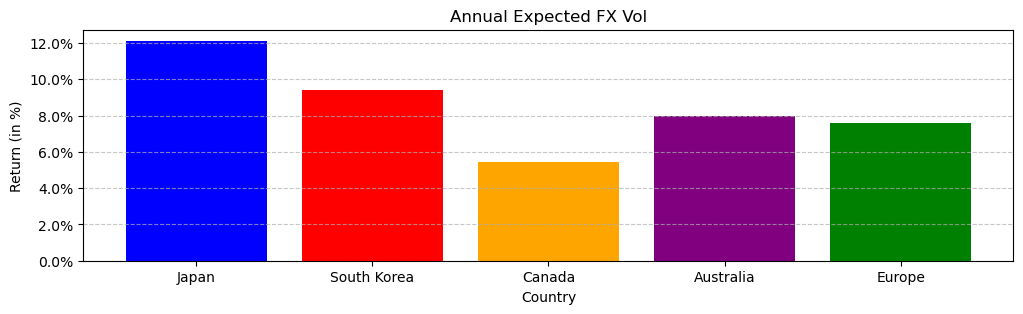

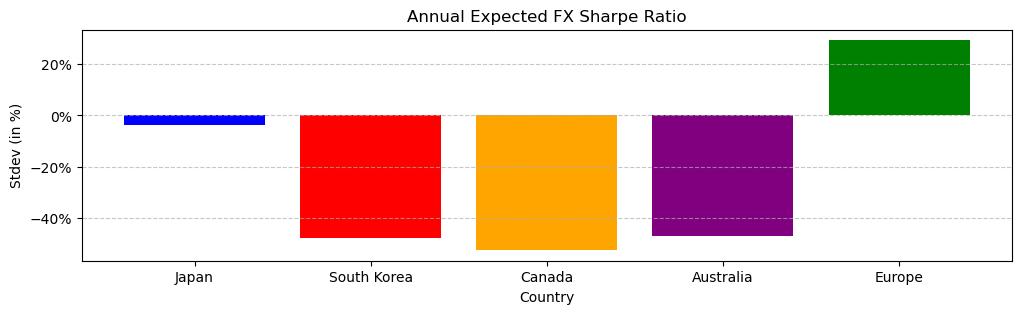

In [10]:

#%% Step 7: Construct Portfolio Optimization Inputs for Currency Overlay
strPeriod = '2024'

ExpectedFXReturn = dfFXReturn[strPeriod :].mean() * dFrequency
# Note: The expected FX return is set to 2% for Japan, 1% for others if you want to test out its impacts on hedging strategy.
#ExpectedFXReturn  = pd.Series(np.array([2, 1, 1, 1, 1])/100, index= dfFXReturn.columns)
ExpectedFXVol  =    dfFXReturn[strPeriod :].std() * np.sqrt(dFrequency)
 
plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = ExpectedFXReturn, color = lColorName)
plt.title('Annual Historical FX Return')
plt.xlabel('Country')
plt.ylabel('Return (in %)')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = ExpectedFXVol, color = lColorName)
plt.title('Annual Expected FX Vol')
plt.xlabel('Country')
plt.ylabel('Return (in %)')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize= (12,3))
plt.bar( x= lCountryTicker , height = ExpectedFXReturn/ExpectedFXVol, color = lColorName)
plt.title('Annual Expected FX Sharpe Ratio')
plt.xlabel('Country')
plt.ylabel('Stdev (in %)')
# Format y-axis to percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Review of Historical Performance: Current vs. New Equity Portfolio

While the expected return of the new portfolio is similar to that of the current portfolio, it achieves lower overall volatility. 
If capital market assumptions are refined to reflect stronger future outperformance of Japanese equities relative to historical trends, the risk-adjusted profile would increasingly favor a higher allocation to Japan.

Expected UnHedged Equity Portfolio Return:  0.14 %
Expected UnHedged Equity Portfolio Return:  0.14 %
Current Equity Portfolio Volatility:  0.19 %
New Equity Portfolio Volatility:  0.11 %


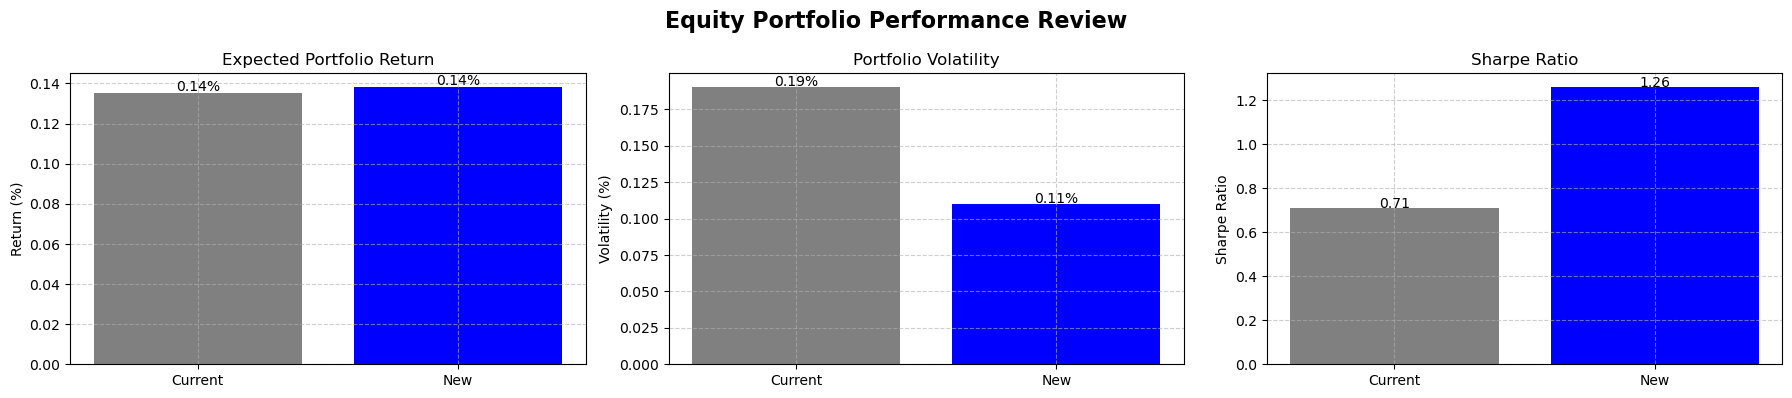

In [11]:

#%% Step 8:Review historical performance of the current vs. new equity portfolio 
 

dExpectedEquityPortReturn = ExpectedEquityReturn @ vNewWeights  
print(f'Expected UnHedged Equity Portfolio Return: {dExpectedEquityPortReturn: .2f} %')

dCurrentPortReturn = ExpectedEquityReturn @ vCurrWeights
print(f'Expected UnHedged Equity Portfolio Return: {dExpectedEquityPortReturn: .2f} %')

sCurPortReturn = dfEquityReturn @ vCurrWeights
dCurrentPortVariance = sCurPortReturn.var() * dFrequency
dCurrentPortVol = np.sqrt(dCurrentPortVariance)
print(f'Current Equity Portfolio Volatility: {dCurrentPortVol: .2f} %')

sNewPortReturn = dfEquityReturn["2024":] @ vNewWeights
dExpectedPortVariance = sNewPortReturn.var() * dFrequency
dExpectedPortVol = np.sqrt(dExpectedPortVariance)
print(f'New Equity Portfolio Volatility: {dExpectedPortVol: .2f} %')

# Risk-free rate
risk_free_rate = 0.0

# Data
lReturns = [dCurrentPortReturn, dExpectedEquityPortReturn]
lVolatilities = [dCurrentPortVol, dExpectedPortVol]
lSharpe_Ratios = [
    (lReturns[0] - risk_free_rate) / lVolatilities[0] if lVolatilities[0] > 0 else 0,
    (lReturns[1] - risk_free_rate) / lVolatilities[1] if lVolatilities[1] > 0 else 0,
]
lLabels = ['Current', 'New']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

plt.suptitle('Equity Portfolio Performance Review', fontsize=16, fontweight='bold')
# Subplot 1: Expected Return
axes[0].bar(lLabels, lReturns, color=['gray', 'blue'])
axes[0].set_title('Expected Portfolio Return')
axes[0].set_ylabel('Return (%)')
axes[0].grid(True, linestyle='--', alpha=0.6)
for i, v in enumerate(lReturns):
    axes[0].text(i, v + 0.001, f'{v:.2f}%', ha='center')

# Subplot 2: Volatility
axes[1].bar(lLabels, lVolatilities, color=['gray', 'blue'])
axes[1].set_title('Portfolio Volatility')
axes[1].set_ylabel('Volatility (%)')
axes[1].grid(True, linestyle='--', alpha=0.6)
for i, v in enumerate(lVolatilities):
    axes[1].text(i, v + 0.001, f'{v:.2f}%', ha='center')

# Subplot 3: Sharpe Ratio
axes[2].bar(lLabels, lSharpe_Ratios, color=['gray', 'blue'])
axes[2].set_title('Sharpe Ratio')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].grid(True, linestyle='--', alpha=0.6)
for i, v in enumerate(lSharpe_Ratios):
    axes[2].text(i, v + 0.001, f'{v:.2f}', ha='center')

# Adjust layout
plt.tight_layout(pad=1.0)
plt.show()

 

### Review of Historical Correlation: New Equity Portfolio vs. Currencies

Using data from 2024, the historical correlation between the new equity portfolio and the Japanese yen shows a strong positive relationship—a notable shift from the traditionally negative correlation observed over longer historical periods.

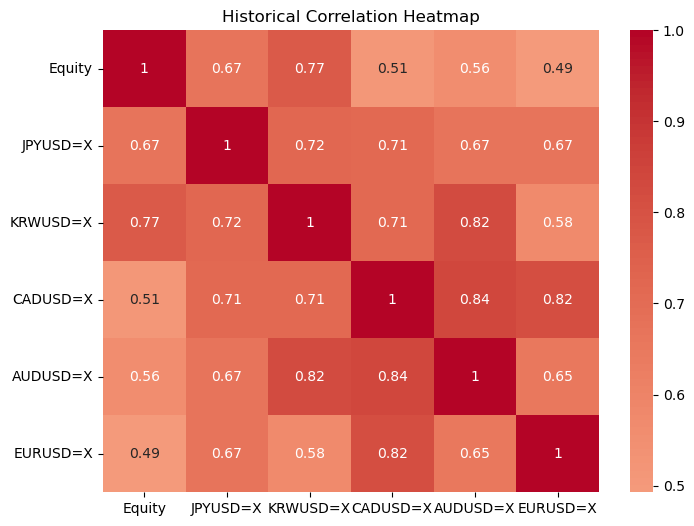

In [12]:
#%% Step 9:Modify and Clean Correlationif necessary

dfCombinedReturn = pd.concat([ sNewPortReturn[strPeriod:].rename("Equity"), dfFXReturn[strPeriod:]], axis=1)

# calculate historical correlation 
dfHistCorrelation = dfCombinedReturn.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(dfHistCorrelation, annot=True, cmap="coolwarm", center=0)
plt.title("Historical Correlation Heatmap")
plt.show()

vEquityIdx = dfHistCorrelation.columns.str.contains("Equity")
vJPYIdx = dfHistCorrelation.columns.str.contains("JPYUSD=X")

dfModCorrelation = dfHistCorrelation.copy()
#dfModCorrelation.iloc[vEquityIdx, vJPYIdx] = 0.5
#dfModCorrelation.iloc[vJPYIdx, vEquityIdx] = 0.5

arr_eigvals = np.linalg.eigvals(dfModCorrelation)
if np.any(arr_eigvals < 0):
    print( "Warning: Modified correlation matrix is not positive semi-definite. Cleaning..." )
    eigvals, eigvecs = np.linalg.eigh(dfModCorrelation)
    eigvals_cleaned = np.where(eigvals < 0, 0, eigvals)
    df_cor_cleaned = eigvecs @ np.diag(eigvals_cleaned) @ eigvecs.T
    D = np.sqrt(np.diag(df_cor_cleaned))
    df_cor_cleaned = df_cor_cleaned / np.outer(D, D)
    np.fill_diagonal(df_cor_cleaned, 1.0)
    df_cor_cleaned = pd.DataFrame(
        df_cor_cleaned, index=dfModCorrelation.index, columns= dfModCorrelation.columns
    )
else:
    dfCleanedCorrelation = dfModCorrelation

dfCleanedCorrelation = dfHistCorrelation
dfCorrelationFX = dfCleanedCorrelation.loc[dfFXReturn.columns, dfFXReturn.columns]
dfCorrelationFXEquity = dfCleanedCorrelation.loc["Equity", dfFXReturn.columns]


Covariance_FX = dfCorrelationFX.to_numpy() * np.outer(
    ExpectedFXVol, ExpectedFXVol
)
 
dfCorrelationFXEquity = dfCorrelationFXEquity.reindex(ExpectedFXVol.index)
Covariance_FX_Equity = dfCorrelationFXEquity.to_numpy()  * ExpectedFXVol.to_numpy() * dExpectedPortVariance 
Covariance_FX_Equity = pd.Series(Covariance_FX_Equity, index = dfCorrelationFXEquity.index) 
 
ExpectedEquityVariance = ExpectedEquityVol ** 2
 


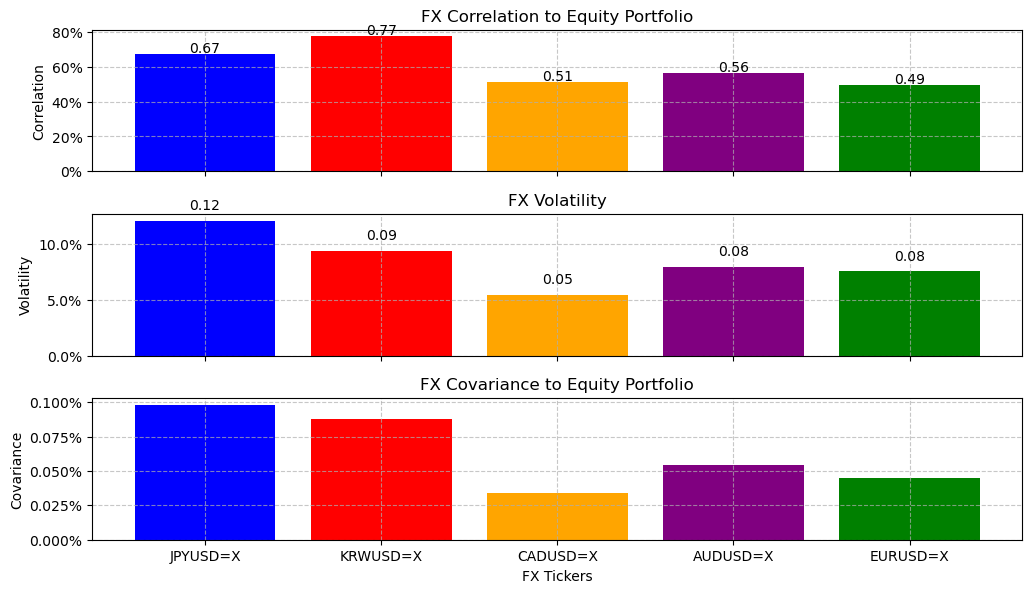

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
axes = axes.flatten()
 

# Subplot 1: FX Correlation
axes[0].bar(dfCorrelationFXEquity.index, dfCorrelationFXEquity.values, color=lColorName)
axes[0].set_title('FX Correlation to Equity Portfolio')
axes[0].set_ylabel('Correlation')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
for i, v in enumerate(dfCorrelationFXEquity.values):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center')

# Subplot 2: FX Volatility
axes[1].bar(ExpectedFXVol.index, ExpectedFXVol.values, color=lColorName)
axes[1].set_title('FX Volatility')
axes[1].set_ylabel('Volatility')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
for i, v in enumerate(ExpectedFXVol.values):
    axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center')

# Subplot 3: FX Covariance
axes[2].bar(Covariance_FX_Equity.index, Covariance_FX_Equity.values, color=lColorName)
axes[2].set_title('FX Covariance to Equity Portfolio')
axes[2].set_xlabel('FX Tickers')
axes[2].set_ylabel('Covariance')
axes[2].tick_params(axis='x', rotation=0)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
 
# Adjust spacing tightly
fig.subplots_adjust(hspace=0.3, top=0.93, bottom=0.08)
# fig.suptitle("FX Risk Characteristics vs Equity Portfolio", fontsize=14)

plt.show()

## Currency Overlay Hedging Optimization


The optimization problem is defined as:

$\max_{h} \mathbb{E}[R_U] + \mathbb{E}[R_H(h)]$

Subject to the following constraints:

Portfolio volatility: $\sigma_P(h) \leq \bar{\sigma}$

Net exposure bounds: $-0.2 \leq (1 - h_i) w_i \leq 0.2$ for each currency $i$

FX tracking error: $\sigma_{FX}(h) \leq \bar{\sigma}_{FX}$

FX equity beta: $\beta_{FX}(h) \leq \bar{\beta}_{FX}$

Where:

$\mathbb{E}[R_U]$: Expected return of the unhedged equity portfolio.

$\mathbb{E}[R_H(h)]$: Expected return from the hedging overlay, typically negative due to hedging costs, computed as $\mathbb{E}[R_H(h)] = -\sum h_i w_i \mathbb{E}[R_{FX,i}]$.

$\sigma_P(h)$: Total portfolio volatility with hedge ratios $h$.

$\sigma_{FX}(h)$: Standalone volatility of the FX exposures.

$\beta_{FX}(h)$: Beta of FX exposures relative to the equity portfolio, defined as $\beta_{FX} = \frac{\text{Cov}(R_U, R_{FX})}{\sigma_U^2}$.


In [ ]:

#%% Step 10: Optimization

vWeights = vNewWeights.copy()
dNumCurrency = len(lCountryTicker)

dTolerance = 0.0001
 
# common industry standard: 50% hedge raio
vBenchmarkNetExposure = (1 - 0.5) * vWeights 
 
dBenchmarkFX_TE = np.sqrt(vBenchmarkNetExposure @ Covariance_FX @ vBenchmarkNetExposure)
print( f'Benchmark FX TE: {dBenchmarkFX_TE: .2f}')

dBenchmarkFXBetatoEquity = ( Covariance_FX_Equity @ vBenchmarkNetExposure) / dExpectedPortVariance
print( f'Benchmark FX Beta to Equity:')
print(dBenchmarkFXBetatoEquity)

 
# Optimization parameters
vTargetPortVolatilities = np.arange(0.05, 0.35, 0.02)
lPortVolatilities = []
lPortReturns = []
lSharpeRatios = []
lHedgeRatios = []
lHedgedWeights = []  # To store hedged weights
lNetExposures = []   # To store net exposures

risk_free_rate = 0.0

# Compute bounds for hedge ratios
lBounds = [(1 - 0.2 / vWeights[i], 1 + 0.2 / vWeights[i]) for i in range(dNumCurrency)]

#lBounds = [(max(0, 1 - 0.2 / vWeights[i]), min(1, 1 + 0.2 / vWeights[i])) for i in range(dNumCurrency)]
lower_bounds = np.array([lb[0] for lb in lBounds])
upper_bounds = np.array([lb[1] for lb in lBounds])
# Define CVXPY variable for hedge ratios
cpHedgeRatio = cp.Variable(dNumCurrency)

# Define net exposure
vNetExposure = cp.multiply(1 - cpHedgeRatio, vWeights)

# Define variance terms
Var_FX = cp.quad_form(vNetExposure, Covariance_FX)
# Convert Covariance_FX_Equity to a NumPy array with correct order
# Assuming dfCorrelationFXEquity and ExpectedFXVol are aligned with vWeights
 
Cov_FX_E = Covariance_FX_Equity.to_numpy() @ vNetExposure 
Var_Portfolio = dExpectedPortVariance + Var_FX + 2 * Cov_FX_E

# Define overlay return
dOverlayReturn = -cp.sum(cp.multiply(cpHedgeRatio, ExpectedFXReturn * vWeights))


# Define hedging costs (e.g., 10 bps cost per unit of notional hedged for each currency)
vHedgingCosts = np.array([0.001] * dNumCurrency)   
cpTotalHedgingCost = cp.sum(cp.multiply(cpHedgeRatio, vHedgingCosts * vWeights))

# Define objective: minimize the negative of total return to maximize it
objective = cp.Minimize(-(dExpectedEquityPortReturn + dOverlayReturn - cpTotalHedgingCost ))

# Optimization loop over target volatilities
for i, dTargetVol in enumerate(vTargetPortVolatilities, start=1):
    print(f'Index {i}, Target Port Vol: {dTargetVol:.2f}')
    
    # Define constraints
    constraints = [
        cpHedgeRatio >= lower_bounds,
        cpHedgeRatio <= upper_bounds,
        Var_Portfolio <= dTargetVol**2,  # Variance constraint
        cp.quad_form(vNetExposure, Covariance_FX) <= dBenchmarkFX_TE**2,  # FX tracking error constraint
        Cov_FX_E <= dBenchmarkFXBetatoEquity * dExpectedPortVariance  # FX equity beta constraint
      
      
    ]
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    if problem.status == 'optimal':
        h_opt = cpHedgeRatio.value
        vol = np.sqrt(Var_Portfolio.value)
        ret = dExpectedEquityPortReturn + dOverlayReturn.value
        sharpe = (ret - risk_free_rate) / vol if vol > 0 else 0
        lPortVolatilities.append(vol)
        lPortReturns.append(ret)
        lSharpeRatios.append(sharpe)
        lHedgeRatios.append(h_opt.copy())
        lHedgedWeights.append(h_opt * vWeights)  # Hedged weight = h_i * w_i
        lNetExposures.append(vNetExposure.value)  # Net exposure = (1 - h_i) * w_i
    else:
        print(f"Optimization failed for target volatility {dTargetVol:.2f}")

# Convert lists to numpy arrays
arrHedgeRatios = np.array(lHedgeRatios)
arrHedgedWeights = np.array(lHedgedWeights)
arrNetExposures = np.array(lNetExposures)

# Ensure alignment of arrays
dMinLength = min(len(lPortVolatilities), len(lHedgeRatios), len(lHedgedWeights), len(lNetExposures))
lPortVolatilities = lPortVolatilities[:dMinLength]
lPortReturns = lPortReturns[:dMinLength]
lSharpeRatios = lSharpeRatios[:dMinLength]
lHedgeRatios = lHedgeRatios[:dMinLength]
lHedgedWeights = lHedgedWeights[:dMinLength]
lNetExposures = lNetExposures[:dMinLength]


Benchmark FX TE:  0.04
Benchmark FX Beta to Equity:
0.024518464840604274
Index 1, Target Port Vol: 0.05
Optimization failed for target volatility 0.05
Index 2, Target Port Vol: 0.07
Optimization failed for target volatility 0.07
Index 3, Target Port Vol: 0.09
Optimization failed for target volatility 0.09
Index 4, Target Port Vol: 0.11
Index 5, Target Port Vol: 0.13
Index 6, Target Port Vol: 0.15
Index 7, Target Port Vol: 0.17
Index 8, Target Port Vol: 0.19
Index 9, Target Port Vol: 0.21
Index 10, Target Port Vol: 0.23
Index 11, Target Port Vol: 0.25
Index 12, Target Port Vol: 0.27
Index 13, Target Port Vol: 0.29
Index 14, Target Port Vol: 0.31
Index 15, Target Port Vol: 0.33


## Overview of the Optimization Results

### Efficient Frontier
The optimization results reveal a highly effective currency hedging strategy designed to maximize portfolio returns while tightly controlling risk. The strategy achieves a positive risk-return trade-off, maintains stable volatility, and strategically adjusts hedge ratios and exposures to manage currency risks. Below is a detailed breakdown of the findings:

Volatility Range: The efficient frontier exhibits a narrow volatility range between 0.1100 and 0.1135 (a span of just 35 basis points), while expected returns improve from 0.154 to 0.164—a 100 basis point increase.
This tight range reflects strong risk control, as volatility is constrained to remain within the level of the benchmark (the unhedged new equity portfolio), FX tracking error, and FX equity beta.

### Optimal Hedge Ratios

General Trend: Hedge ratios for major currencies—such as the Japanese yen and the euro—are relatively stable and close to 1, indicating full or slight over-hedging. South Korea and Canada are notable exceptions.

Drivers of Over-Hedging: The over-hedging tendency is driven by negative expected FX returns, based on simple historical estimates. Anticipated depreciation of the Korean won (KRW) and Canadian dollar (CAD) makes over-hedging a potentially profitable strategy to mitigate currency losses or lock in gains.

### Net Currency Exposures

Since the euro was the only currency with a positive expected return, the model under-hedges euro exposure while over-hedging other currencies—particularly the South Korean won and Canadian dollar—due to their expected depreciation.

### Conclusion

Overall, this strategy effectively manages currency risk while improving expected portfolio returns and reducing volatility—aligning with the advanced hedging framework outlined in the PIMCO paper "Beyond Currency Hedging."

**Incorporating more sophisticated forward-looking market assumptions** can make the optimization results more realistic than relying solely on historical data. For example, modeling FX returns based on real interest rate differentials and fundamental valuations can reduce the tendency to over-hedge. If we anticipate a further depreciation of the U.S. dollar in the coming years—similar to the trend seen in the early 2000s—over-hedging would likely decrease as the model adjusts to more favorable FX return expectations.


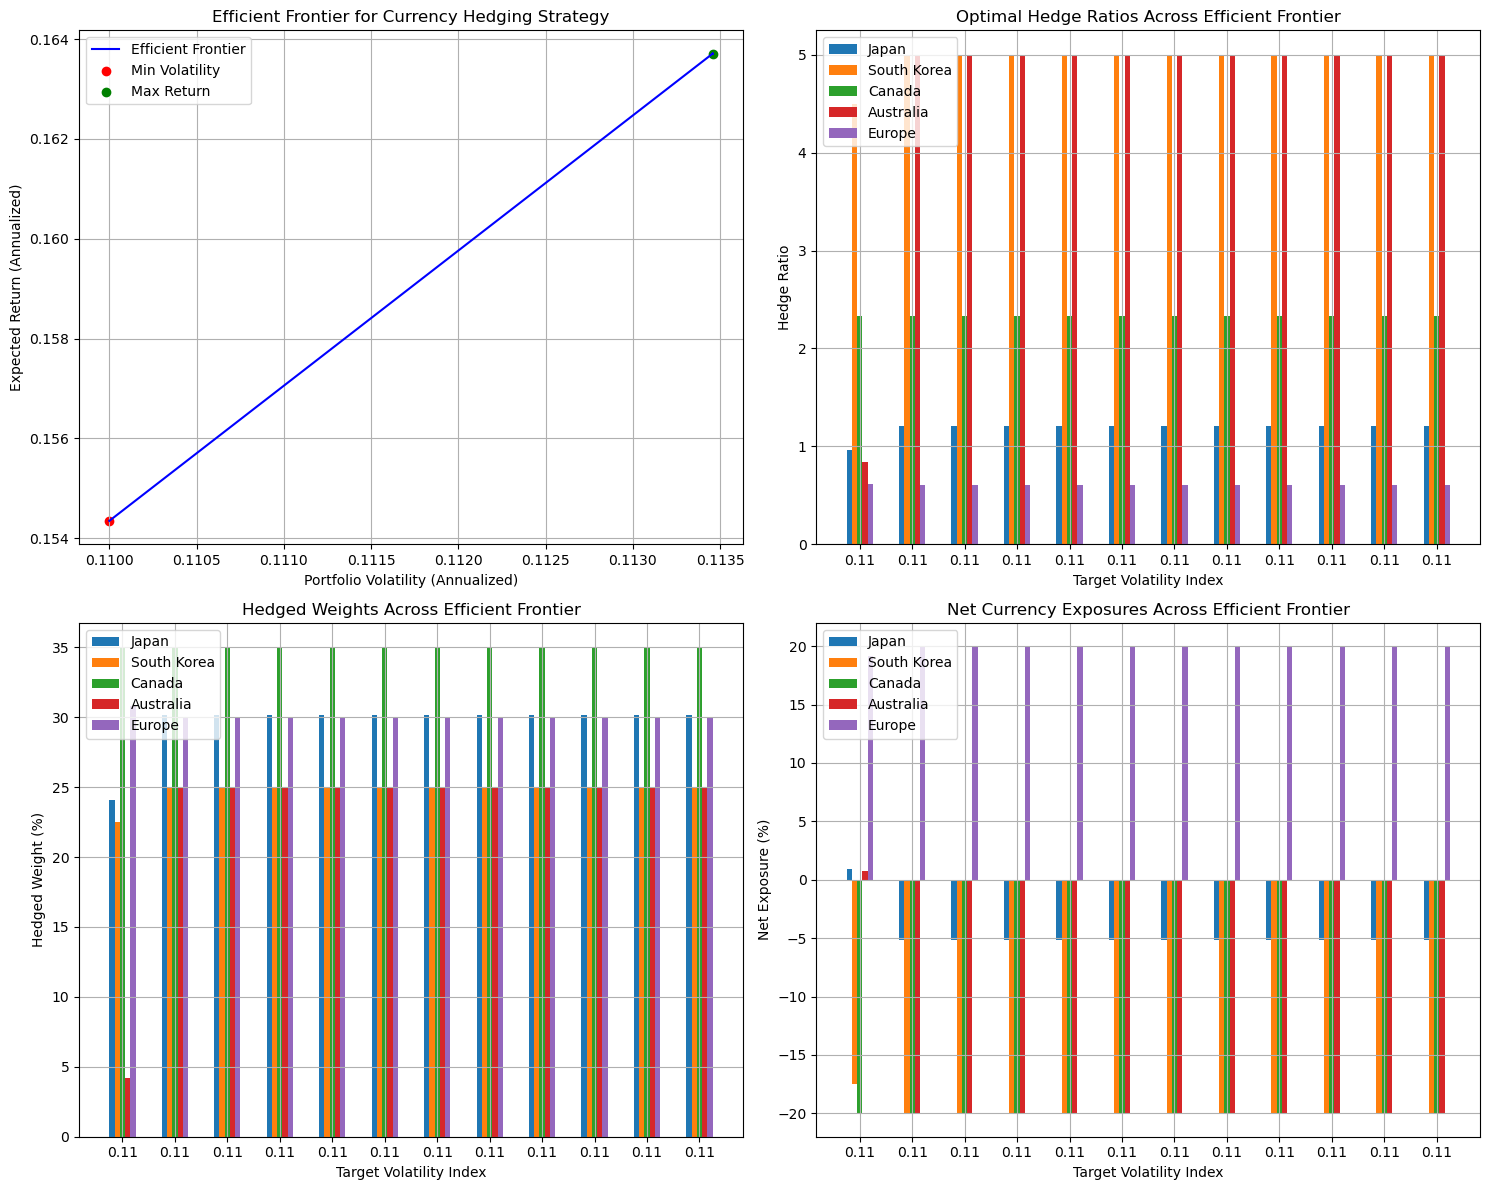

In [ ]:
#%% Step 12: Review Optimization Results

plt.figure(figsize=(15, 12))

# Efficient Frontier
plt.subplot(2, 2, 1)
plt.plot(lPortVolatilities, lPortReturns, 'b-', label='Efficient Frontier')
plt.scatter(lPortVolatilities[0], lPortReturns[0], c='r', label='Min Volatility')
plt.scatter(lPortVolatilities[-1], lPortReturns[-1], c='g', label='Max Return')
 # plot current portfolio
#plt.scatter(dCurrentPortVol, dCurrentPortReturn, c="b", label="Current UnHedged Portfolio")
#plt.scatter(dExpectedPortVol, dExpectedEquityPortReturn, c="gold", label="New UnHedged Portfolio")
plt.xlabel('Portfolio Volatility (Annualized)')
plt.ylabel('Expected Return (Annualized)')
plt.title('Efficient Frontier for Currency Hedging Strategy')
plt.legend()
plt.grid(True)

# Hedge Ratios Plot (Bar Plot)
plt.subplot(2, 2, 2)
bar_width = 0.1
index = np.arange(len(lPortVolatilities))
if len(lPortVolatilities) > 0:
    for i in range(dNumCurrency):
        plt.bar(index + i * bar_width, arrHedgeRatios[index, i], bar_width, label= lCountryTicker[i])
    plt.xlabel('Target Volatility Index')
    plt.ylabel('Hedge Ratio')
    plt.title('Optimal Hedge Ratios Across Efficient Frontier')
    plt.xticks(index + bar_width * (dNumCurrency - 1) / 2, [f'{v:.2f}' for v in lPortVolatilities])
    plt.legend()
    plt.grid(True)
else:
    print("No valid optimization results to plot hedge ratios.")

# Hedged Weights Plot (Bar Plot)
plt.subplot(2, 2, 3)
if len(lPortVolatilities) > 0:
    for i in range(dNumCurrency):
        plt.bar(index + i * bar_width, arrHedgedWeights[index, i] * 100, bar_width, label=lCountryTicker[i] )  # Convert to percentage
    plt.xlabel('Target Volatility Index')
    plt.ylabel('Hedged Weight (%)')
    plt.title('Hedged Weights Across Efficient Frontier')
    plt.xticks(index + bar_width * (dNumCurrency - 1) / 2, [f'{v:.2f}' for v in lPortVolatilities])
    plt.legend()
    plt.grid(True)
else:
    print("No valid optimization results to plot hedged weights.")

# Net Exposures Plot (Bar Plot)
plt.subplot(2, 2, 4)
if len(lPortVolatilities) > 0:
    for i in range(dNumCurrency):
        plt.bar(index + i * bar_width, arrNetExposures[index, i] * 100, bar_width, label= lCountryTicker[i])  # Convert to percentage
    plt.xlabel('Target Volatility Index')
    plt.ylabel('Net Exposure (%)')
    plt.title('Net Currency Exposures Across Efficient Frontier')
    plt.xticks(index + bar_width * (dNumCurrency - 1) / 2, [f'{v:.2f}' for v in lPortVolatilities])
    plt.legend()
    plt.grid(True)
else:
    print("No valid optimization results to plot net exposures.")

plt.tight_layout()
plt.show()